In [ ]:
# Page 154 of Python for Algorithmic Trading from idea to cloud deployment 
# Machine Learning
# Deep Learning using TensorFlow (Keras actually)
# To predict the market returns

In [2]:
import pandas as pd
import random 
import numpy as np 
from pylab import mpl, plt 
plt.style.use('seaborn') 



In [3]:
symbol = 'EUR='
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)   # ------------------------------------------------------

In [5]:
# Causually,  we create features by lags which we can create more meaningfully  
lags = 5
cols = [] 

for lag in range(1, lags + 1): 
    col = f'lag_{lag}' 
    data[col] = data['return'].shift(lag) 
    cols.append(col) 
    data.dropna(inplace=True)

data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


# Applying DNN (Dense Neural Network) with Keras Package

In [11]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam, RMSprop


In [12]:
optimizer = Adam ( learning_rate=0.0001)

In [13]:
def set_seeds(seed=100): 
    random.seed(seed) 
    np.random.seed(seed)
    tf.random.set_seed(100)


In [14]:
set_seeds() 
model = Sequential() 
model.add(Dense(64, activation='relu', input_shape=(lags,))) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
cutoff = '2017-12-31'
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std


In [16]:
%%time
model.fit(training_data[cols], training_data['direction'], epochs=50, verbose=False, validation_split=0.2, shuffle=False)


Wall time: 7.13 s


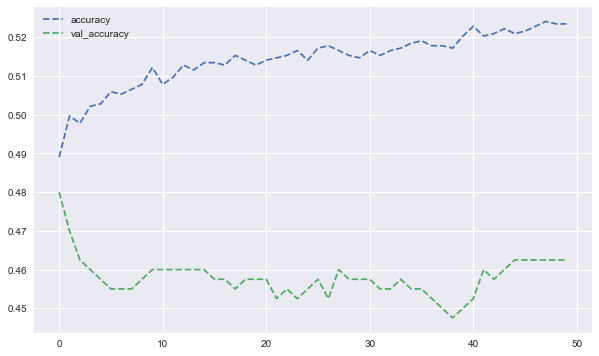

In [17]:
res = pd.DataFrame(model.history.history)

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');


In [18]:
model.evaluate(training_data_[cols], training_data['direction'])


63/63 [==============================] - 0s 2ms/step - loss: 0.7726 - accuracy: 0.5138


[0.7725757956504822, 0.5137706398963928]

In [38]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
pred[:30].flatten()


array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1])

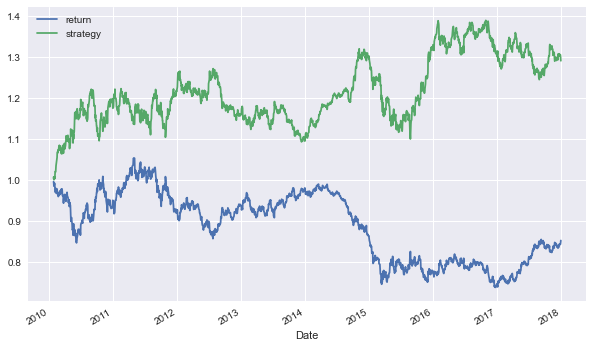

In [21]:
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)
training_data[['return', 'strategy']].cumsum( ).apply(np.exp).plot(figsize=(10, 6));


In [22]:
model.evaluate(test_data_[cols], test_data['direction'])


16/16 [==============================] - 0s 2ms/step - loss: 0.7401 - accuracy: 0.5089


[0.7400631904602051, 0.5089462995529175]

In [23]:
# Now trying on test data..... Can encouraging results 

pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()


-1    350
 1    153
Name: prediction, dtype: int64

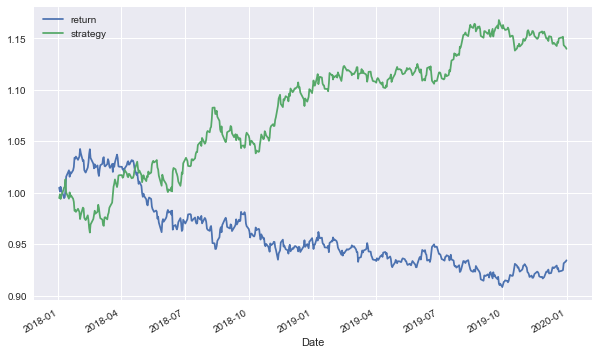

In [24]:
test_data['strategy'] = (test_data['prediction'] * test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'strategy']].cumsum( ).apply(np.exp).plot(figsize=(10, 6));


# Now is the REAL THING ..........     
#  Adding REAL features 

In [27]:
# Adding Momemtum
data['momentum'] = data['return'].rolling(5).mean().shift(1)
# Adding Volatility
data['volatility'] = data['return'].rolling(20).std().shift(1)
# Check this diatnace ?---------------------------------------------------May be distance travlled in Pips-------------
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

data.dropna(inplace=True)

cols.extend(['momentum', 'volatility', 'distance'])

print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [28]:
# Data preparation
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [29]:
set_seeds() 
model = Sequential() 
model.add(Dense(32, activation='relu', input_shape=(len(cols),))) #input parameter changed to reflect new number of features 
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
%%time 
model.fit(training_data_[cols], training_data['direction'], verbose=False, epochs=25)

Wall time: 2.85 s


In [31]:
model.evaluate(training_data_[cols], training_data['direction'])

58/58 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.5755


[0.6802798509597778, 0.5755279064178467]

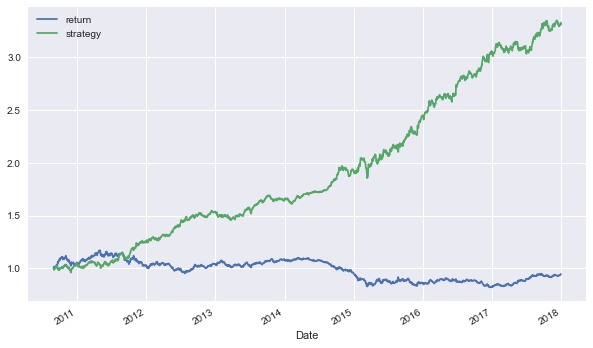

In [32]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)
training_data[['return', 'strategy']].cumsum( ).apply(np.exp).plot(figsize=(10, 6));

#This is In-Sample testing & graph

In [33]:
# Now, Out of sample test data shall be used

model.evaluate(test_data_[cols], test_data['direction']) 

16/16 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5268


[0.6922677159309387, 0.5268389582633972]

In [34]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

-1    295
 1    208
Name: prediction, dtype: int64

In [35]:
test_data['strategy'] = (test_data['prediction'] * test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.977760
dtype: float64

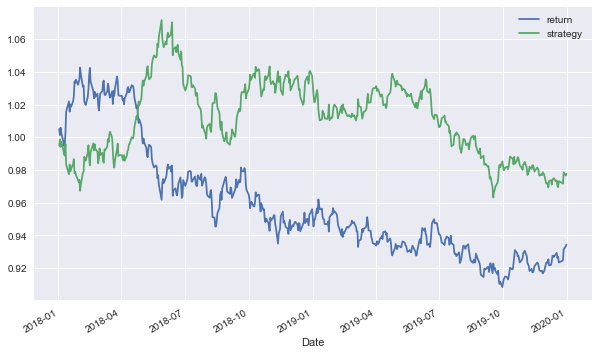

In [36]:
test_data[['return', 'strategy']].cumsum( ).apply(np.exp).plot(figsize=(10, 6));